In [1]:
import numpy as np 
import pandas as pd 
import statsmodels.api as sm
import h5_utilities_module as h5u
import matplotlib.pyplot as plt
from pathlib import Path
import pingouin as pg

In [2]:
# where are the data?
data_dir = '/Users/thomaselston/Documents/PYTHON/self_control/ensemble_dropping/'

# get the names/paths of the files
data_files = h5u.find_h5_files(data_dir)

In [8]:
#functions
def calculate_mean_and_interval(data, type='sem', num_samples=1000, alpha=0.05):
    """
    Calculate mean and either SEM or bootstrapped CI for each column of the input array, disregarding NaN values.

    Parameters:
    - data: 2D numpy array
    - type: str, either 'sem' or 'bootstrap_ci'
    - num_samples: int, number of bootstrap samples (applicable only for type='bootstrap_ci')
    - alpha: float, significance level for the confidence interval (applicable only for type='bootstrap_ci')

    Returns:
    - means: 1D numpy array containing means for each column
    - interval: 1D numpy array containing SEMs or bootstrapped CIs for each column
    """
    nan_mask = ~np.isnan(data)
    
    nanmean_result = np.nanmean(data, axis=0)
    n_valid_values = np.sum(nan_mask, axis=0)
    
    if type == 'sem':
        nanstd_result = np.nanstd(data, axis=0)
        interval = nanstd_result / np.sqrt(n_valid_values)
        
    elif type == 'percentile':
        interval = np.nanmean(np.array([np.abs(nanmean_result - np.nanpercentile (data, 5, axis=0)), np.abs(nanmean_result - np.nanpercentile (data, 95, axis=0))]))
        
    elif type == 'bootstrap':

        # Check if data is a 1D array (scalar vector)
        if data.ndim == 1:
            data = data.reshape(-1, 1)  # Reshape to (n, 1)
            nan_mask = nan_mask.reshape(-1, 1)  # Reshape to (n, 1)
            
        n_rows, n_cols = data.shape

        # Initialize array to store bootstrap means
        bootstrap_means = np.zeros((num_samples, n_cols))

        # Perform bootstrap resampling for each column
        for col in range(n_cols):
            
            if np.sum(nan_mask[:, col]) > 0:
                bootstrap_samples = np.random.choice(data[:, col][nan_mask[:, col]], size=(num_samples, n_rows), replace=True)
                bootstrap_means[:, col] = np.nanmean(bootstrap_samples, axis=1)
            else:
                bootstrap_means[:, col] = np.nan

        # Calculate confidence interval bounds
        ci_lower = np.percentile(bootstrap_means, 100 * (alpha / 2), axis=0)
        ci_upper = np.percentile(bootstrap_means, 100 * (1 - alpha / 2), axis=0)
        
        interval = np.nanmean([abs(bootstrap_means - ci_lower), abs(bootstrap_means - ci_upper)], axis=0)
        
        interval = np.nanmean(interval, axis=0)

    else:
        raise ValueError("Invalid 'type' argument. Use either 'sem' or 'bootstrap'.")
    
    # Ensure that the output is a scalar if there is only one value
    if nanmean_result.size == 1:
        nanmean_result = nanmean_result.item()  # Convert array to scalar
    if interval.size == 1:
        interval = interval.item()  # Convert array to scalar
    
    return nanmean_result, interval


In [ ]:
h5u.list_hdf5_data(data_files[0])

In [4]:
# initialize variables
bhv = pd.DataFrame()

ofc_all_acc = []
ofc_no_A_acc = []
ofc_no_B_acc = []
ofc_no_C_acc = []

cdn_all_acc = []
cdn_no_A_acc = []
cdn_no_B_acc = []
cdn_no_C_acc = []


# loop over the files and extract the data
for this_file in data_files:
    
    f_name = Path(this_file).stem
    print(f_name)
    
    bhv = pd.concat([bhv, pd.read_hdf(this_file, key='bhv')], ignore_index=True)

    ofc_all_acc.append(h5u.pull_from_h5(this_file, 'ofc_all_acc'))
    ofc_no_A_acc.append(h5u.pull_from_h5(this_file, 'ofc_no_A_acc'))
    ofc_no_B_acc.append(h5u.pull_from_h5(this_file, 'ofc_no_B_acc'))
    ofc_no_C_acc.append(h5u.pull_from_h5(this_file, 'ofc_no_C_acc'))

    cdn_all_acc.append(h5u.pull_from_h5(this_file, 'cdn_all_acc'))
    cdn_no_A_acc.append(h5u.pull_from_h5(this_file, 'cdn_no_A_acc'))
    cdn_no_B_acc.append(h5u.pull_from_h5(this_file, 'cdn_no_B_acc'))
    cdn_no_C_acc.append(h5u.pull_from_h5(this_file, 'cdn_no_C_acc'))

# convert lists to arrays

ofc_all_acc = np.concatenate(ofc_all_acc, axis=0)
ofc_no_A_acc = np.concatenate(ofc_no_A_acc, axis=0)
ofc_no_B_acc = np.concatenate(ofc_no_B_acc, axis=0)
ofc_no_C_acc = np.concatenate(ofc_no_C_acc, axis=0)

cdn_all_acc = np.concatenate(cdn_all_acc, axis=0)
cdn_no_A_acc = np.concatenate(cdn_no_A_acc, axis=0)
cdn_no_B_acc = np.concatenate(cdn_no_B_acc, axis=0)
cdn_no_C_acc = np.concatenate(cdn_no_C_acc, axis=0)

D20231224_Rec07_ensemble_dropping
K20240715_Rec09_ensemble_dropping
D20231219_Rec05_ensemble_dropping
K20240712_Rec08_ensemble_dropping
K20240710_Rec07_ensemble_dropping
D20231221_Rec06_ensemble_dropping
K20240707_Rec06_ensemble_dropping
D20231227_Rec08_ensemble_dropping


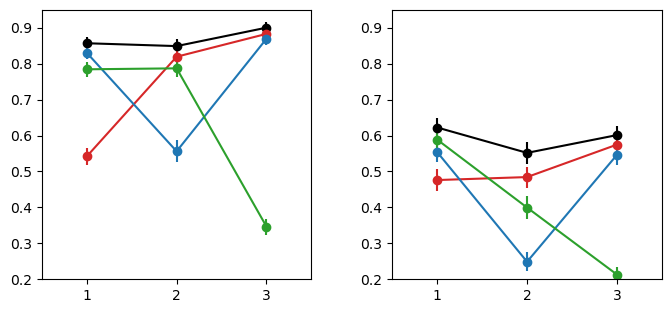

In [26]:
k_ix = bhv['fname'].str.contains('K')
d_ix = bhv['fname'].str.contains('D')

s1_ix = bhv['state'] == 1
s2_ix = bhv['state'] == 2
s3_ix = bhv['state'] == 3

sacc_ix = bhv['n_sacc'] == 1

fig, ax = plt.subplots(1, 2, figsize = (8, 3.5))
plt.subplots_adjust(wspace=0.3)  # add some white space

for i in range(2):

    if i == 0:
        subj_ix = k_ix
    else:
        subj_ix = d_ix #| k_ix

    # initialize arrays
    ofc_acc_means = np.zeros((4,3))
    ofc_acc_CIs = np.zeros((4,3))

    ofc_acc_means[0,0], ofc_acc_CIs[0,0] = calculate_mean_and_interval(ofc_all_acc[s1_ix & subj_ix & sacc_ix], 'bootstrap')
    ofc_acc_means[0,1], ofc_acc_CIs[0,1] = calculate_mean_and_interval(ofc_all_acc[s2_ix & subj_ix & sacc_ix], 'bootstrap')
    ofc_acc_means[0,2], ofc_acc_CIs[0,2] = calculate_mean_and_interval(ofc_all_acc[s3_ix & subj_ix & sacc_ix], 'bootstrap')

    ofc_acc_means[1,0], ofc_acc_CIs[1,0] = calculate_mean_and_interval(ofc_no_A_acc[s1_ix & subj_ix & sacc_ix], 'bootstrap')
    ofc_acc_means[1,1], ofc_acc_CIs[1,1] = calculate_mean_and_interval(ofc_no_A_acc[s2_ix & subj_ix & sacc_ix], 'bootstrap')
    ofc_acc_means[1,2], ofc_acc_CIs[1,2] = calculate_mean_and_interval(ofc_no_A_acc[s3_ix & subj_ix & sacc_ix], 'bootstrap')

    ofc_acc_means[2,0], ofc_acc_CIs[2,0] = calculate_mean_and_interval(ofc_no_B_acc[s1_ix & subj_ix & sacc_ix], 'bootstrap')
    ofc_acc_means[2,1], ofc_acc_CIs[2,1] = calculate_mean_and_interval(ofc_no_B_acc[s2_ix & subj_ix & sacc_ix], 'bootstrap')
    ofc_acc_means[2,2], ofc_acc_CIs[2,2] = calculate_mean_and_interval(ofc_no_B_acc[s3_ix & subj_ix & sacc_ix], 'bootstrap')

    ofc_acc_means[3,0], ofc_acc_CIs[3,0] = calculate_mean_and_interval(ofc_no_C_acc[s1_ix & subj_ix & sacc_ix], 'bootstrap')
    ofc_acc_means[3,1], ofc_acc_CIs[3,1] = calculate_mean_and_interval(ofc_no_C_acc[s2_ix & subj_ix & sacc_ix], 'bootstrap')
    ofc_acc_means[3,2], ofc_acc_CIs[3,2] = calculate_mean_and_interval(ofc_no_C_acc[s3_ix & subj_ix & sacc_ix], 'bootstrap')

    ax[i].errorbar([1,2,3], ofc_acc_means[0,:], ofc_acc_CIs[0,:], color='black', marker='o')
    ax[i].errorbar([1,2,3], ofc_acc_means[1,:], ofc_acc_CIs[1,:], color='tab:red', marker='o')
    ax[i].errorbar([1,2,3], ofc_acc_means[2,:], ofc_acc_CIs[2,:], color='tab:blue', marker='o')
    ax[i].errorbar([1,2,3], ofc_acc_means[3,:], ofc_acc_CIs[3,:], color='tab:green', marker='o')
    ax[i].set_ylim((.2, .95))
    ax[i].set_xlim((.5, 3.5))
    ax[i].set_xticks((1,2,3))

fig.savefig("ensemble_dropping_fig.svg")